In [ ]:
#! pip install -q kaggle
from google.colab import files

files.upload()  # Choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yitzhakgrinvald","key":"e174162200b831fe822116cd99c868d4"}'}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd


Make directory named kaggle and copy kaggle.json file ther

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

Change the permissions of the file:

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

100% 225M/225M [00:06<00:00, 41.5MB/s]
100% 225M/225M [00:06<00:00, 36.7MB/s]


In [ ]:
!unzip -qq flowers-recognition.zip

Preparing the folders for splitting into train, val, test

In [ ]:
import os
import glob

# Define the source and target directories
source_parent_directory = "flowers"
target_parent_directory = "flowers_new"

# Ensure the target directory exists
os.makedirs(target_parent_directory, exist_ok=True)

# Iterate over the flower categories
flower_categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for category in flower_categories:
    source_directory = os.path.join(source_parent_directory, category)
    target_directory = os.path.join(target_parent_directory, category)

    # Ensure the target directory for the current category exists
    os.makedirs(target_directory, exist_ok=True)

    # Initialize a counter for the new numeric names
    new_name_counter = 0

    # Iterate over image files in the source directory (assuming they are in .jpg format)
    for image_file in glob.glob(os.path.join(source_directory, "*.jpg")):
        # Generate the new filename with the desired format (e.g., "0.jpg", "1.jpg", ...)
        new_filename = f"{new_name_counter}.jpg"

        # Create the new file's full path in the target directory
        target_filepath = os.path.join(target_directory, new_filename)

        # Rename and move the file
        os.rename(image_file, target_filepath)

        # Increment the counter for the next file
        new_name_counter += 1



Splitting the data into train, val, test

In [ ]:
import shutil
import pathlib

original_dir = pathlib.Path("flowers_new")
new_base_dir = pathlib.Path("flowers_new_split")

def make_subset(subset_name, start_index, end_index):
    for category in ("daisy", "dandelion", "rose","sunflower",  "tulip"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Create directories if they don't exist
        fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:

            src_path = original_dir / category / fname
            dst_path = dir / fname
            shutil.copyfile(src=src_path, dst=dst_path)

make_subset("train", start_index=0, end_index=590)
make_subset("validation", start_index=590, end_index=660)
make_subset("test", start_index=660, end_index=730)


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2950 files belonging to 5 classes.
Found 350 files belonging to 5 classes.
Found 350 files belonging to 5 classes.


The Base Model 1 (optimizer= "rmsprop")

In [ ]:
num_classes = 5


# Input layer
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

# Convolutional layers with max pooling
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:


num_classes = 5

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
93/93 [==============================] - 19s 69ms/step - loss: 1.4669 - accuracy: 0.3603 - val_loss: 1.2723 - val_accuracy: 0.4657
Epoch 2/10
93/93 [==============================] - 7s 73ms/step - loss: 1.1949 - accuracy: 0.5044 - val_loss: 1.2333 - val_accuracy: 0.5457
Epoch 3/10
93/93 [==============================] - 6s 61ms/step - loss: 1.0564 - accuracy: 0.5827 - val_loss: 1.2225 - val_accuracy: 0.5229
Epoch 4/10
93/93 [==============================] - 7s 72ms/step - loss: 0.9788 - accuracy: 0.6298 - val_loss: 1.1911 - val_accuracy: 0.5714
Epoch 5/10
93/93 [==============================] - 6s 59ms/step - loss: 0.8921 - accuracy: 0.6651 - val_loss: 1.1430 - val_accuracy: 0.5971
Epoch 6/10
93/93 [==============================] - 7s 73ms/step - loss: 0.8206 - accuracy: 0.7020 - val_loss: 1.0542 - val_accuracy: 0.6229
Epoch 7/10
93/93 [==============================] - 6s 62ms/step - loss: 0.7409 - accuracy: 0.7227 - val_loss: 1.0417 - val_accuracy: 0.6686
Epoch 8/10
9

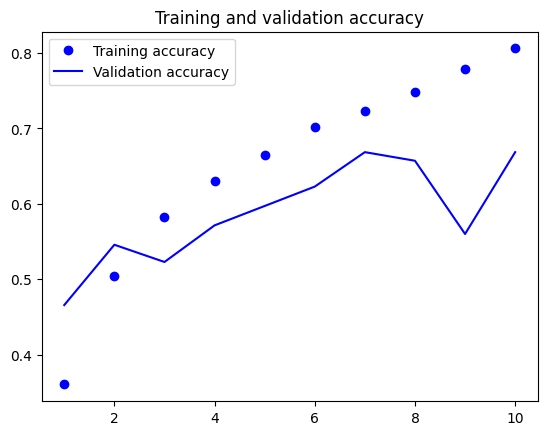

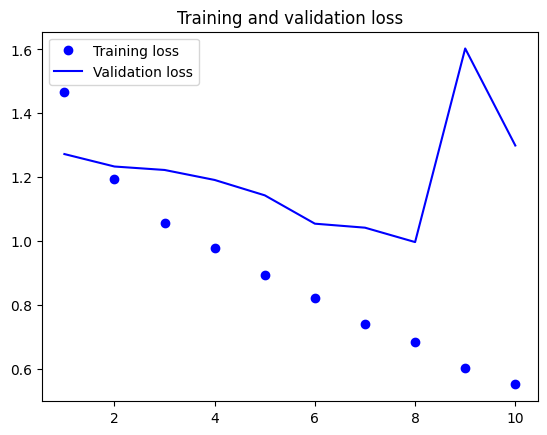

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("Flower_identification.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
basic_model1= ['basic_model_rmsprop',str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")

11/11 [==============================] - 1s 24ms/step - loss: 0.8432 - accuracy: 0.6743
Test accuracy: 0.674


The Base Model 2 (optimizer= "adam")

In [ ]:


# Input layer
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

# Convolutional layers with max pooling
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)
import tensorflow as tf
from tensorflow import keras
num_classes = 5

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification2.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
93/93 [==============================] - 10s 63ms/step - loss: 1.3096 - accuracy: 0.4197 - val_loss: 1.4934 - val_accuracy: 0.4171
Epoch 2/10
93/93 [==============================] - 7s 71ms/step - loss: 1.1277 - accuracy: 0.5383 - val_loss: 1.1901 - val_accuracy: 0.4971
Epoch 3/10
93/93 [==============================] - 6s 60ms/step - loss: 1.0023 - accuracy: 0.5973 - val_loss: 0.9852 - val_accuracy: 0.6171
Epoch 4/10
93/93 [==============================] - 7s 75ms/step - loss: 0.9239 - accuracy: 0.6444 - val_loss: 0.9132 - val_accuracy: 0.6429
Epoch 5/10
93/93 [==============================] - 6s 63ms/step - loss: 0.8203 - accuracy: 0.6881 - val_loss: 1.1587 - val_accuracy: 0.6371
Epoch 6/10
93/93 [==============================] - 7s 75ms/step - loss: 0.7592 - accuracy: 0.7085 - val_loss: 1.0698 - val_accuracy: 0.6629
Epoch 7/10
93/93 [==============================] - 7s 73ms/step - loss: 0.7155 - accuracy: 0.7292 - val_loss: 0.9477 - val_accuracy: 0.6743
Epoch 8/10
9

In [ ]:
test_model = keras.models.load_model("Flower_identification2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
basic_model2= ['basic_model_adam',str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")

11/11 [==============================] - 1s 22ms/step - loss: 0.8282 - accuracy: 0.6857
Test accuracy: 0.686


# Using data augmentation

### Define a data augmentation stage to add to an image model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
num_classes = 5

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=14,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/14
93/93 [==============================] - 9s 78ms/step - loss: 1.3788 - accuracy: 0.3946 - val_loss: 1.3196 - val_accuracy: 0.4600
Epoch 2/14
93/93 [==============================] - 7s 66ms/step - loss: 1.1999 - accuracy: 0.4969 - val_loss: 1.1299 - val_accuracy: 0.5257
Epoch 3/14
93/93 [==============================] - 7s 66ms/step - loss: 1.0713 - accuracy: 0.5800 - val_loss: 1.0066 - val_accuracy: 0.5914
Epoch 4/14
93/93 [==============================] - 7s 72ms/step - loss: 1.0249 - accuracy: 0.6024 - val_loss: 1.3390 - val_accuracy: 0.5057
Epoch 5/14
93/93 [==============================] - 6s 62ms/step - loss: 0.9495 - accuracy: 0.6403 - val_loss: 1.0009 - val_accuracy: 0.6286
Epoch 6/14
93/93 [==============================] - 7s 73ms/step - loss: 0.9201 - accuracy: 0.6586 - val_loss: 1.4781 - val_accuracy: 0.4629
Epoch 7/14
93/93 [==============================] - 6s 63ms/step - loss: 0.8870 - accuracy: 0.6641 - val_loss: 0.9802 - val_accuracy: 0.6143
Epoch 8/14
93

**Training the regularized networks**

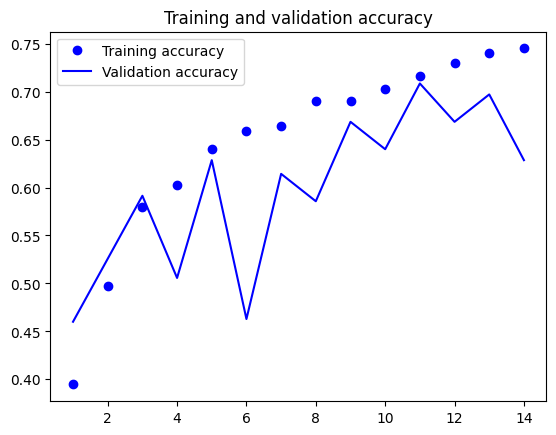

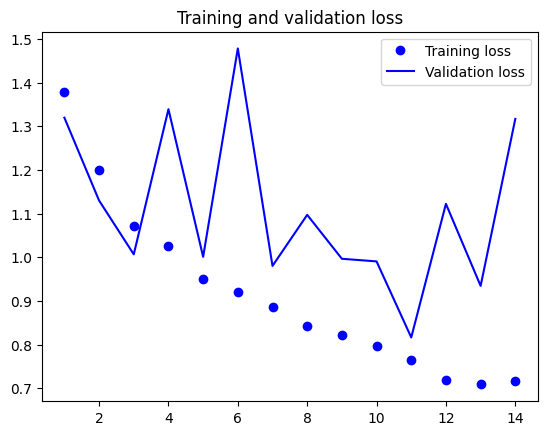

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**evaluating the the new model**

In [ ]:
test_model = keras.models.load_model(
    "Flower_identification_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
augm_model= ['augm_model',str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")


11/11 [==============================] - 1s 24ms/step - loss: 0.7487 - accuracy: 0.7257
Test accuracy: 0.726


In [ ]:
num_classes = 5

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification_with_augmentation_adam.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=14,
    validation_data=validation_dataset,
    callbacks=callbacks)


test_model = keras.models.load_model(
    "Flower_identification_with_augmentation_adam.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
augm_model_adam= ['augm_model_adam',str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")


Epoch 1/14
93/93 [==============================] - 10s 77ms/step - loss: 1.3891 - accuracy: 0.3620 - val_loss: 1.2097 - val_accuracy: 0.4600
Epoch 2/14
93/93 [==============================] - 6s 63ms/step - loss: 1.1496 - accuracy: 0.5336 - val_loss: 1.0419 - val_accuracy: 0.5829
Epoch 3/14
93/93 [==============================] - 8s 79ms/step - loss: 1.0265 - accuracy: 0.5939 - val_loss: 0.9671 - val_accuracy: 0.6343
Epoch 4/14
93/93 [==============================] - 6s 64ms/step - loss: 0.9742 - accuracy: 0.6278 - val_loss: 1.0176 - val_accuracy: 0.6200
Epoch 5/14
93/93 [==============================] - 7s 75ms/step - loss: 0.9554 - accuracy: 0.6298 - val_loss: 1.0819 - val_accuracy: 0.6086
Epoch 6/14
93/93 [==============================] - 6s 62ms/step - loss: 0.8656 - accuracy: 0.6617 - val_loss: 1.0032 - val_accuracy: 0.6257
Epoch 7/14
93/93 [==============================] - 7s 75ms/step - loss: 0.8515 - accuracy: 0.6708 - val_loss: 0.9798 - val_accuracy: 0.6543
Epoch 8/14
9

# Leveraging a pretrained model

**Feature extraction with a pretrained model**

Instantiating the VGG16 convolutional base

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_dataset, epochs=14, validation_data=validation_dataset, callbacks=callbacks)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/14
93/93 [==============================] - 46s 363ms/step - loss: 1.8681 - accuracy: 0.2359 - val_loss: 1.5958 - val_accuracy: 0.2286
Epoch 2/14
93/93 [==============================] - 28s 295ms/step - loss: 1.5509 - accuracy: 0.3159 - val_loss: 3.2787 - val_accuracy: 0.3229
Epoch 3/14
93/93 [==============================] - 29s 305ms/step - loss: 1.1306 - accuracy: 0.5603 - val_loss: 0.9533 - val_accuracy: 0.6429
Epoch 4/14
93/93 [==============================] - 29s 309ms/step - loss: 0.8926 - accuracy: 0.6634 - val_loss: 1.3633 - val_accuracy: 0.6057
Epoch 5/14
93/93 [==============================] - 28s 298ms/step - loss: 0.7233 - accuracy: 0.7444 - val_loss: 1.1746 - val_accuracy: 0.6971
Epoch 6/14
93/93 [==============================] - 30s 314ms/step - loss: 0.6034 - accuracy: 0.7942 - val_loss: 0.6175 - val_accuracy: 0.8029
Epoch 7/14
93/93 [==============================] - 29s 307ms/step - loss: 0.

In [ ]:
test_accuracy = model.evaluate(test_dataset)
VGG16_model= ['VGG16_model',str(test_accuracy[1])]
print("Test accuracy:", test_accuracy[1])


11/11 [==============================] - 1s 90ms/step - loss: 0.6780 - accuracy: 0.8286
Test accuracy: 0.8285714387893677


improve the model by add dropout and regularization

In [ ]:
from tensorflow.keras.regularizers import l2

num_classes = 5

# Input layer
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# Data preprocessing layer (you can keep this as it is)
x = layers.Rescaling(1./255)(inputs)

# Convolutional layers with max pooling
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)



Epoch 1/20
93/93 [==============================] - 11s 82ms/step - loss: 2.7696 - accuracy: 0.3475 - val_loss: 1.9240 - val_accuracy: 0.3400
Epoch 2/20
93/93 [==============================] - 7s 69ms/step - loss: 1.3945 - accuracy: 0.5034 - val_loss: 1.4247 - val_accuracy: 0.4600
Epoch 3/20
93/93 [==============================] - 8s 83ms/step - loss: 1.2361 - accuracy: 0.5458 - val_loss: 1.2204 - val_accuracy: 0.5457
Epoch 4/20
93/93 [==============================] - 8s 81ms/step - loss: 1.1281 - accuracy: 0.5895 - val_loss: 1.0862 - val_accuracy: 0.5857
Epoch 5/20
93/93 [==============================] - 7s 71ms/step - loss: 1.0533 - accuracy: 0.6210 - val_loss: 1.0322 - val_accuracy: 0.6514
Epoch 6/20
93/93 [==============================] - 8s 80ms/step - loss: 0.9758 - accuracy: 0.6620 - val_loss: 1.0037 - val_accuracy: 0.6600
Epoch 7/20
93/93 [==============================] - 8s 84ms/step - loss: 0.9710 - accuracy: 0.6617 - val_loss: 1.1148 - val_accuracy: 0.6200
Epoch 8/20
9

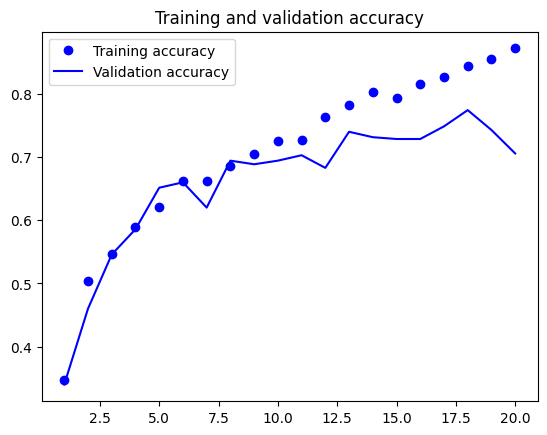

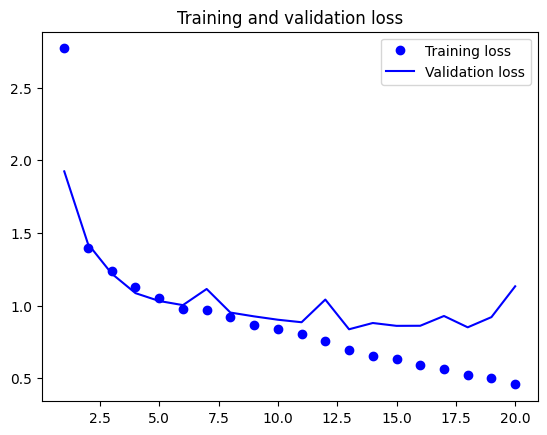

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**evaluating the the new model**

In [ ]:
test_model = keras.models.load_model(
    "Flower_identification_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
regular_model= ['regular_model',str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")


11/11 [==============================] - 1s 24ms/step - loss: 0.7992 - accuracy: 0.7429
Test accuracy: 0.743


In [ ]:
# regular_model= ['regular_model',0.831]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model architecture
model = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation flow for training dataset
train_datagen = datagen.flow_from_directory(
    'flowers_new_split/train',
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse'
)

# Validation dataset
validation_dataset = image_dataset_from_directory(
    'flowers_new_split/validation',
    image_size=(180, 180),
    batch_size=32
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification_with_augmentation_new_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
# Train the model with data augmentation
history = model.fit(
    train_datagen,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Found 2950 images belonging to 5 classes.
Found 350 files belonging to 5 classes.
Epoch 1/30
93/93 [==============================] - 30s 300ms/step - loss: 1.4513 - accuracy: 0.3803 - val_loss: 1.2255 - val_accuracy: 0.4486
Epoch 2/30
93/93 [==============================] - 28s 300ms/step - loss: 1.1826 - accuracy: 0.5244 - val_loss: 1.1120 - val_accuracy: 0.5429
Epoch 3/30
93/93 [==============================] - 28s 305ms/step - loss: 1.1063 - accuracy: 0.5593 - val_loss: 1.0367 - val_accuracy: 0.5743
Epoch 4/30
93/93 [==============================] - 29s 308ms/step - loss: 1.0261 - accuracy: 0.5976 - val_loss: 0.9668 - val_accuracy: 0.6086
Epoch 5/30
93/93 [==============================] - 29s 304ms/step - loss: 0.9794 - accuracy: 0.6186 - val_loss: 0.9179 - val_accuracy: 0.6314
Epoch 6/30
93/93 [==============================] - 28s 300ms/step - loss: 0.9386 - accuracy: 0.6383 - val_loss: 0.9025 - val_accuracy: 0.6514
Epoch 7/30
93/93 [==============================] - 27s 292m

In [ ]:
test_model = keras.models.load_model(
    "Flower_identification_with_augmentation_new_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
aug_new_model= ["aug_new_model",str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")


11/11 [==============================] - 1s 23ms/step - loss: 0.6096 - accuracy: 0.7743
Test accuracy: 0.774


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="Flower_identification_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))  # Adjust the output layer units according to your number of flower classes (5 in this case)
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_dataset, epochs=14, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/14
93/93 [==============================] - 33s 304ms/step - loss: 1.8570 - accuracy: 0.2820 - val_loss: 1.3505 - val_accuracy: 0.3829
Epoch 2/14
93/93 [==============================] - 28s 296ms/step - loss: 1.2740 - accuracy: 0.5207 - val_loss: 1.0393 - val_accuracy: 0.5914
Epoch 3/14
93/93 [==============================] - 29s 307ms/step - loss: 0.9604 - accuracy: 0.6356 - val_loss: 1.0373 - val_accuracy: 0.6429
Epoch 4/14
93/93 [==============================] - 28s 296ms/step - loss: 0.7855 - accuracy: 0.7132 - val_loss: 1.0653 - val_accuracy: 0.6400
Epoch 5/14
93/93 [==============================] - 28s 296ms/step - loss: 0.7352 - accuracy: 0.7420 - val_loss: 1.3023 - val_accuracy: 0.5857
Epoch 6/14
93/93 [==============================] - 28s 295ms/step - loss: 0.6527 - accuracy: 0.7803 - val_loss: 0.6250 - val_accuracy: 0.7600
Epoch 7/14
93/93 [==============================] - 28s 295ms/step - loss: 0.5657 - accuracy: 0.8132 - val_loss: 0.8688 - val_accuracy: 0.7314

In [ ]:
test_model = keras.models.load_model(
    "Flower_identification_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
VGG16_new_model= ["VGG16_new_model ",str(test_acc)]
print(f"Test accuracy: {test_acc:.3f}")


11/11 [==============================] - 1s 23ms/step - loss: 0.7992 - accuracy: 0.7429
Test accuracy: 0.743


Inserting all the accuracy results of the model into the array and displaying the improvement on a graph

In [ ]:
model_result= [basic_model1,basic_model2,  augm_model  ,augm_model_adam, regular_model, aug_new_model, VGG16_model]
for model in model_result:
  print(model)

['basic_model_rmsprop', '0.6742857098579407']
['basic_model_adam', '0.6857143044471741']
['augm_model', '0.7257142663002014']
['augm_model_adam', '0.7342857122421265']
['regular_model', '0.7428571581840515']
['aug_new_model', '0.7742857336997986']
['VGG16_model', 0.802]


In [ ]:
# model_result= [['basic_model_rmsprop', '0.6742857098579407'],
# ['basic_model_adam', '0.6857143044471741'],
# ['augm_model', '0.7257142663002014'],
# ['augm_model_adam', '0.7342857122421265'],
# ['regular_model', '0.7428571581840515'],
# ['aug_new_model', '0.7742857336997986'],
# ['VGG16_model', '0.828']]

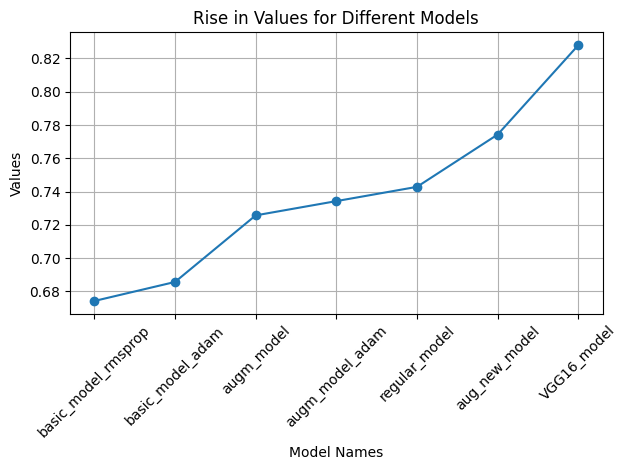

In [ ]:
import matplotlib.pyplot as plt

model_names = []
values = []

for entry in model_result:
    model_names.append(entry[0])
    values.append(float(entry[1]))

fig, ax = plt.subplots()

ax.plot(model_names, values, marker='o', linestyle='-')
ax.set_xlabel('Model Names')
ax.set_ylabel('Values')
ax.set_title('Rise in Values for Different Models')

plt.xticks(rotation=45) # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()